# Examples GEM EO datasets of derived data

This is a notebook showcasing workflow examples for downloading EO derived data from data collections available through Sentinel Hub.

### Data download examples in this notebook:

1.  Sentinel-2 L2A 120m Mosaic

2.  Corine Land Cover

3.  Corine Land Cover Accounting Layers

4.  ESA WorldCover

5.  Global Land Cover

6.  Global Surface Water

7.  Global Human Settlements Layer 

8.  Theia Land Cover Map

9.  Sentinel-2 Scene Classification Layer (from Sen2cor) 



In [1]:
%matplotlib inline
import datetime

import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
from aenum import MultiValueEnum
from eolearn.core import EOPatch, FeatureType
from eolearn.io import SentinelHubDemTask, SentinelHubEvalscriptTask, SentinelHubInputTask, get_available_timestamps
from matplotlib.colors import BoundaryNorm, ListedColormap

from sentinelhub import CRS, Band, BBox, DataCollection, MimeType, SentinelHubRequest, SHConfig, Unit

### General parameters

In [2]:
# region of interest
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
roi1_bbox = BBox(bbox=[4.972687, 43.495772, 5.637360, 43.855326], crs=CRS.WGS84)
large_bbox = BBox(bbox=[-10.524902, 33.651208, 11.711426, 44.213710], crs=CRS.WGS84)
coast_bbox = BBox(bbox=[-0.05, 40.23, 0.61, 40.63], crs=CRS.WGS84)

Function for showing colormaps

In [3]:
def rgb_int(row):
    hex_val = row[2]
    rgb_val = matplotlib.colors.to_rgb(hex_val)
    return rgb_val

###  1.  Sentinel-2 L2A 120m Mosaic ( [Sentinel-2 L2A 120m Mosaic](https://collections.sentinel-hub.com/sentinel-s2-l2a-mosaic-120/) )

In [4]:
S2_mosaic_data_collection = DataCollection.define_byoc(
    "484d8dbb-9e3e-41f2-b96b-35189d3ae37f",
    service_url="https://services.sentinel-hub.com",
    bands=[
        Band(name="B02", units=(Unit.DN,), output_types=(np.uint16)),
        Band(name="B03", units=(Unit.DN,), output_types=(np.uint16)),
        Band(name="B04", units=(Unit.DN,), output_types=(np.uint16)),
    ],
)

In [5]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03","B04"],
    output: [
        {
          id: "bands",
          bands: 3,
          sampleType: "UINT16"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.B02, sample.B03, sample.B04];
}
"""

In [6]:
mosaic_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript,
    data_collection=S2_mosaic_data_collection,
    resolution=120,
    max_threads=3,
)

In [7]:
eopatch_mosaic = mosaic_download_task.execute(bbox=coast_bbox, time_interval=["2020-07-01", "2020-07-15"])

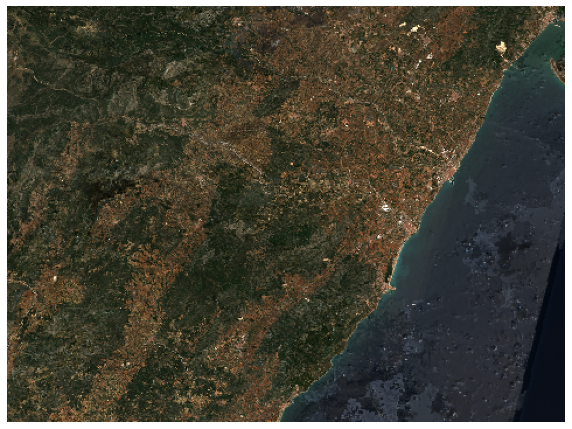

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(np.clip(eopatch_mosaic.data["bands"][1][..., [2, 1, 0]] / 10000 * 2.5, 0, 1), vmin=0, vmax=1)
plt.axis(False);

### 2. Corine Land Cover ( [CLC](https://collections.sentinel-hub.com/corine-land-cover/) ) 

In [124]:
clc_data_collection = DataCollection.define_byoc(
    "cbdba844-f86d-41dc-95ad-b3f7f12535e9",
    service_url="https://creodias.sentinel-hub.com",
    bands=[Band(name="CLC", units=(Unit.DN,), output_types=(np.uint8))],
)

In [125]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["CLC"],
    output: [
        {
          id: "CLC_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.CLC];
}
"""

In [126]:
clc_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "CLC_data"),
    evalscript=evalscript,
    data_collection=clc_data_collection,
    resolution=30,
    max_threads=3,
)

In [127]:
eopatch_clc = clc_download_task.execute(bbox=coast_bbox, time_interval=["2017-01-01", "2019-01-01"])

In [144]:
class CLC(MultiValueEnum):
    """Enum class containing CORINE Land Cover types"""

    CONTINUOUS_URBAN_FABRIC = "Continuous urban fabric", 111, "#E6004D", 1
    DISCONTINUOUS_URBAN_FABRIC = "Discontinuous urban fabric", 112, "#FF0000", 2
    INDUSTRIAL_OR_COMMERCIAL_UNITS = "Industrial or commercial units", 121, "#CC4DF2", 3
    ROAD_AND_RAIL_NETWORKS_AND_ASSOCIATED_LAND = "Road and rail networks and associated land", 122, "#CC0000", 4
    PORT_AREAS = "Port areas", 123, "#E6CCCC", 5
    AIRPORTS = "Airports", 124, "#E6CCE6", 6
    MINERAL_EXTRACTION_SITES = "Mineral extraction sites", 131, "#A600CC", 7
    DUMP_SITES = "Dump sites", 132, "#A64D00", 8
    CONSTRUCTION_SITES = "Construction sites", 133, "#FF4DFF", 9
    GREEN_URBAN_AREAS = "Green urban areas", 141, "#FFA6FF", 10
    SPORT_AND_LEISURE_FACILITIES = "Sport and leisure facilities", 142, "#FFE6FF", 11
    NON_IRRIGATED_ARABLE_LAND = "Non-irrigated arable land", 211, "#FFFFA8", 12
    PERMANENTLY_IRRIGATED_LAND = "Permanently irrigated land", 212, "#FFFF00", 13
    RICE_FIELDS = "Rice fields", 213, "#E6E600", 14
    VINEYARDS = "Vineyards", 221, "#E68000", 15
    FRUIT_TREES_AND_BERRY_PLANTATIONS = "Fruit trees and berry plantations", 222, "#F2A64D", 16
    OLIVE_GROVES = "Olive groves", 223, "#E6A600", 17
    PASTURES = "Pastures", 231, "#E6E64D", 18
    ANNUAL_CROPS_ASSOCIATED_WITH_PERMANENT_CROPS = "Annual crops associated with permanent crops", 241, "#FFE6A6", 19
    COMPLEX_CULTIVATION_PATTERNS = "Complex cultivation patterns", 242, "#FFE64D", 20
    LAND_PRINCIPALLY_OCCUPIED_BY_AGRICULTURE_WITH_SIGNIFICANT_AREAS_OF_NATURAL_VEGETATION = (
        "Land principally occupied by agriculture with significant areas of natural vegetation",
        243,
        "#E6CC4D",
        21,
    )
    AGRO_FORESTRY_AREAS = "Agro-forestry areas", 244, "#F2CCA6", 22
    BROAD_LEAVED_FOREST = "Broad-leaved forest", 311, "#80FF00", 23
    CONIFEROUS_FOREST = "Coniferous forest", 312, "#00A600", 24
    MIXED_FOREST = "Mixed forest", 313, "#4DFF00", 25
    NATURAL_GRASSLANDS = "Natural grasslands", 321, "#CCF24D", 26
    MOORS_AND_HEATHLAND = "Moors and heathland", 322, "#A6FF80", 27
    SCLEROPHYLLOUS_VEGETATION = "Sclerophyllous vegetation", 323, "#A6E64D", 28
    TRANSITIONAL_WOODLAND_SHRUB = "Transitional woodland-shrub", 324, "#A6F200", 29
    BEACHES__DUNES__SANDS = "Beaches - dunes - sands", 331, "#E6E6E6", 30
    BARE_ROCKS = "Bare rocks", 332, "#CCCCCC", 31
    SPARSELY_VEGETATED_AREAS = "Sparsely vegetated areas", 333, "#CCFFCC", 32
    BURNT_AREAS = "Burnt areas", 334, "#000000", 33
    GLACIERS_AND_PERPETUAL_SNOW = "Glaciers and perpetual snow", 335, "#A6E6CC", 34
    INLAND_MARSHES = "Inland marshes", 411, "#A6A6FF", 35
    PEAT_BOGS = "Peat bogs", 412, "#4D4DFF", 36
    SALT_MARSHES = "Salt marshes", 421, "#CCCCFF", 37
    SALINES = "Salines", 422, "#E6E6FF", 38
    INTERTIDAL_FLATS = "Intertidal flats", 423, "#A6A6E6", 39
    WATER_COURSES = "Water courses", 511, "#00CCF2", 40
    WATER_BODIES = "Water bodies", 512, "#80F2E6", 41
    COASTAL_LAGOONS = "Coastal lagoons", 521, "#00FFA6", 42
    ESTUARIES = "Estuaries", 522, "#A6FFE6", 43
    SEA_AND_OCEAN = "Sea and ocean", 523, "#E6F2FF", 44
    NODATA = "NODATA", 999, "#FFFFFF", 48

In [213]:
CLC_sub = []
CLC_un = np.unique(eopatch_clc.data["CLC_data"])

for i, entry in enumerate(CLC):
    if np.isin(entry.values[3], CLC_un):
        CLC_sub.append([entry.values[0], entry.values[1], entry.values[2], entry.values[3]])

clc_bounds = [CLC_sub[0][3] - 0.5]
[clc_bounds.append((0.5 + entry[3])) for entry in CLC_sub]
clc_ticks = [np.mean([clc_bounds[i], clc_bounds[i - 1]]) for i in range(1, len(clc_bounds))]

clc_cmap = ListedColormap([rgb_int(entry) for entry in CLC_sub], name="clc_cmap")
clc_norm = BoundaryNorm(clc_bounds, clc_cmap.N)

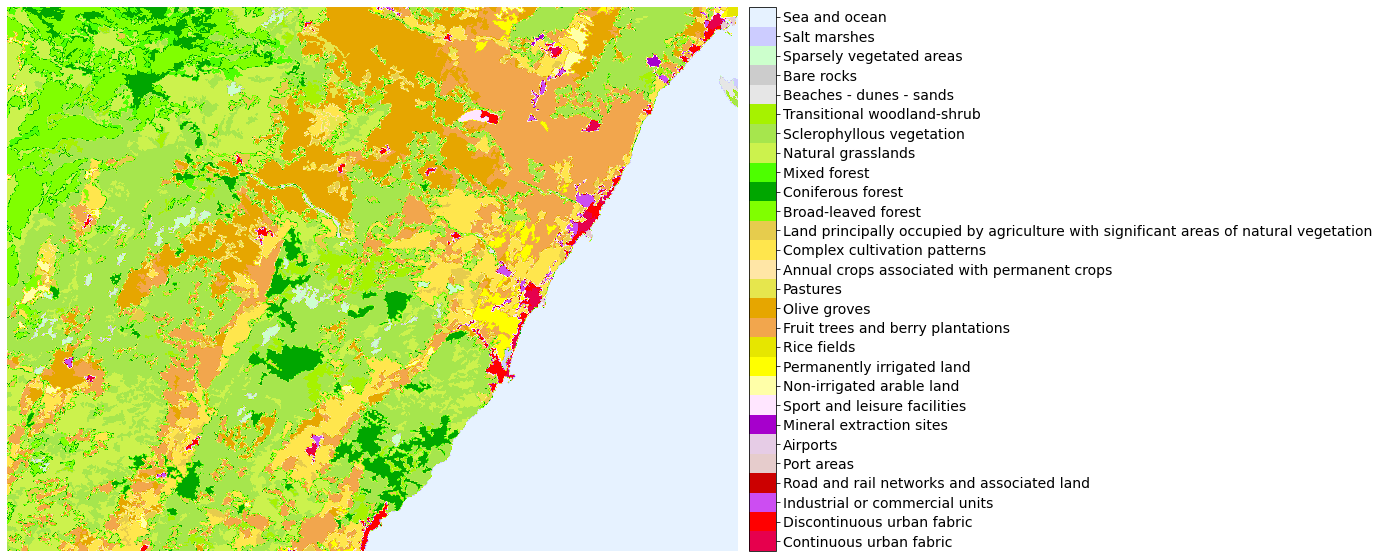

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = plt.imshow(eopatch_clc.data["CLC_data"][0].squeeze(), cmap=clc_cmap, norm=clc_norm)
plt.axis(False)

cb = fig.colorbar(im, orientation="vertical", pad=0.01, aspect=20)
cb.set_ticks(clc_ticks)
cb.set_ticklabels([entry[0] for entry in CLC_sub], fontsize=14);

### 3. Corine Land Cover Accounting Layers ( [CLC_ACC](https://collections.sentinel-hub.com/corine-land-cover-accounting-layers/) ) 

In [164]:
clcacc_data_collection = DataCollection.define_byoc(
    "4c5441a6-6040-4dc4-a392-c1317bbd1031",
    service_url="https://creodias.sentinel-hub.com",
    bands=[Band(name="CLC_ACC", units=(Unit.DN,), output_types=(np.uint8))],
)

In [165]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["CLC_ACC"],
    output: [
        {
          id: "CLC_ACC_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.CLC_ACC];
}
"""

In [166]:
clcacc_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "CLC_ACC_data"),
    evalscript=evalscript,
    data_collection=clcacc_data_collection,
    resolution=30,
    max_threads=3,
)

In [167]:
eopatch_clcacc = clcacc_download_task.execute(bbox=roi1_bbox, time_interval=["2017-01-01", "2019-01-01"])

In [206]:
CLC_sub = []
CLC_un = np.unique(eopatch_clcacc.data["CLC_ACC_data"])

for i, entry in enumerate(CLC):
    if np.isin(entry.values[1], CLC_un):
        CLC_sub.append([entry.values[0], entry.values[1], entry.values[2], entry.values[3]])

clc_bounds = [CLC_sub[0][1] - 0.5]
[clc_bounds.append((0.5 + entry[1])) for entry in CLC_sub]
clc_ticks = [np.mean([clc_bounds[i], clc_bounds[i - 1]]) for i in range(1, len(clc_bounds))]

clc_cmap = ListedColormap([rgb_int(entry) for entry in CLC_sub], name="clc_cmap")
clc_norm = BoundaryNorm(clc_bounds, clc_cmap.N)

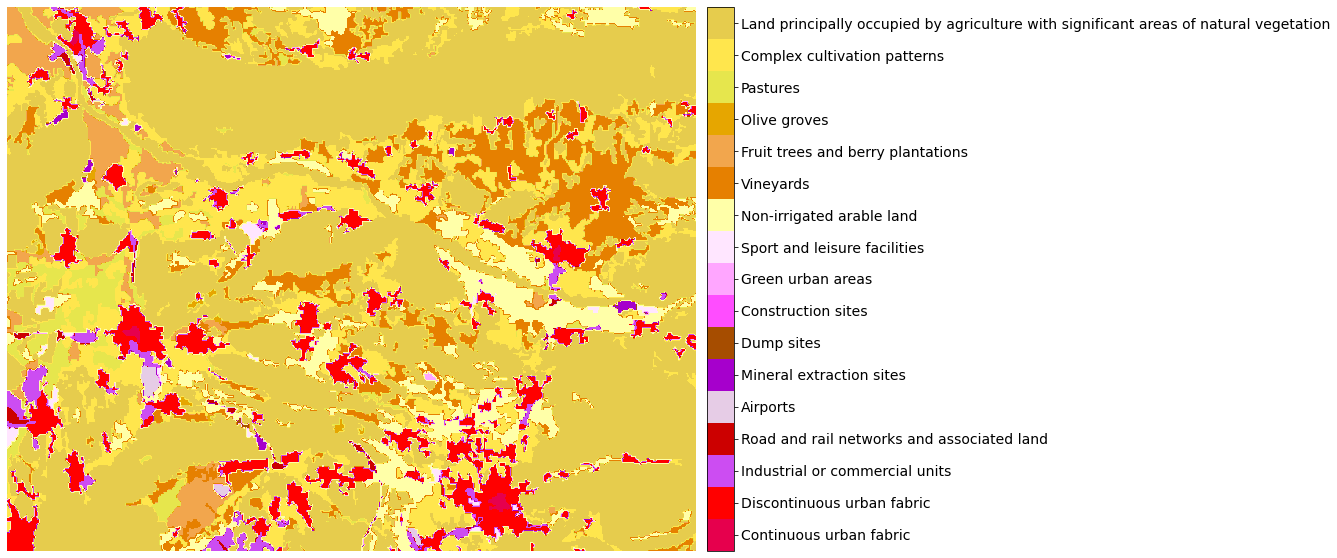

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = plt.imshow(eopatch_clcacc.data["CLC_ACC_data"][0].squeeze(), cmap=clc_cmap, norm=clc_norm)
plt.axis(False)

cb = fig.colorbar(im, orientation="vertical", pad=0.01, aspect=20)
cb.set_ticks(clc_ticks)
cb.set_ticklabels([entry[0] for entry in CLC_sub], fontsize=14);

### 4. ESA WorldCover ( [EWC](https://collections.sentinel-hub.com/worldcover/ ) )

In [99]:
ewc_data_collection = DataCollection.define_byoc(
    "0b940c63-45dd-4e6b-8019-c3660b81b884",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name="Map", units=(Unit.DN,), output_types=(np.uint8))],
)

In [100]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["Map"],
    output: [
        {
          id: "EWC_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.Map];
}
"""

In [101]:
ewc_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "EWC_data"),
    evalscript=evalscript,
    data_collection=ewc_data_collection,
    resolution=30,
    max_threads=3,
)

In [216]:
eopatch_ewc = ewc_download_task.execute(bbox=roi1_bbox, time_interval=["2020-01-01", "2020-01-01"])

In [217]:
class EWC(MultiValueEnum):
    """Enum class containing basic LULC EWC types"""

    NO_DATA = "No data", 0, "black"
    TREE_COVER = "Tree cover", 10, "darkgreen"
    SHRUBLAND = "Shrubland", 20, "orange"
    GRASSLAND = "Grassland", 30, "yellow"
    CROPLAND = "Cropland", 40, "violet"
    BUILT_UP = "Built up", 50, "red"
    BARE_SPARSE_VEGETATION = "Bare /sparse vegetation", 60, "dimgrey"
    SNOW_ICE = "Snow and Ice", 70, "silver"
    PERMANENT_WATER_BODIES = "Permanent water bodies", 80, "blue"
    HERBACEOUS_WETLAND = "Herbaceous wetland", 90, "darkcyan"
    MANGROVES = "Mangroves", 95, "springgreen"
    MOSS_LICHEN = "Moss and lichen", 100, "khaki"

In [228]:
EWC_sub = []
EWC_un = np.unique(eopatch_ewc.data["EWC_data"])

for i, entry in enumerate(EWC):
    if np.isin(entry.values[1], EWC_un):
        EWC_sub.append([entry.values[0], entry.values[1], entry.values[2]])

ewc_bounds = [EWC_sub[0][1] - 0.5]
[ewc_bounds.append((0.5 + entry[1])) for entry in EWC_sub]
ewc_ticks = [np.mean([ewc_bounds[i], ewc_bounds[i - 1]]) for i in range(1, len(ewc_bounds))]

ewc_cmap = ListedColormap([entry[2] for entry in EWC_sub], name="ewc_cmap")
ewc_norm = BoundaryNorm(ewc_bounds, ewc_cmap.N)

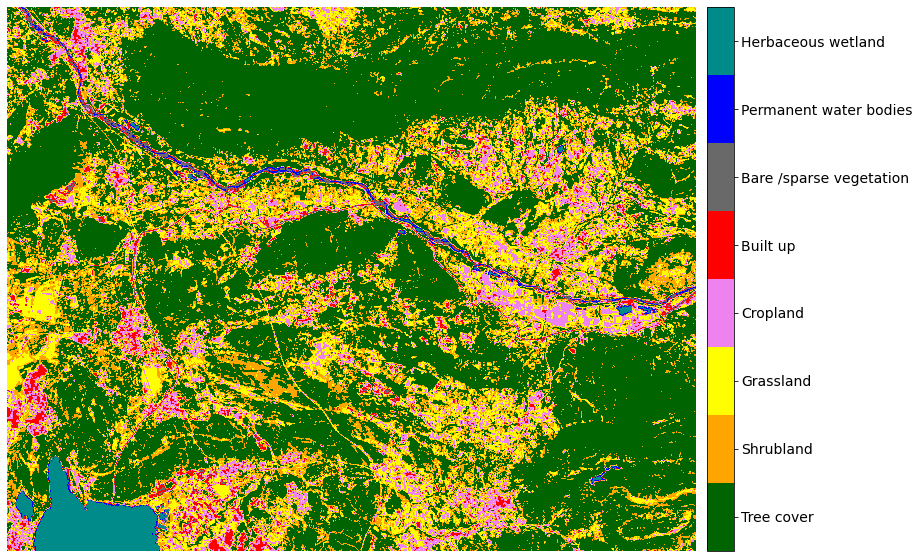

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im1 = plt.imshow(eopatch_ewc.data["EWC_data"].squeeze(), cmap=ewc_cmap, norm=ewc_norm)
plt.imshow(eopatch_ewc.data["EWC_data"].squeeze(), cmap=ewc_cmap)
plt.axis(False)

cb = fig.colorbar(im1, orientation="vertical", pad=0.01, aspect=20)
cb.set_ticks(ewc_ticks)
cb.set_ticklabels([entry[0] for entry in EWC_sub], fontsize=14);


### 5.  Global Land Cover ( [GLC](https://collections.sentinel-hub.com/global-land-cover/) )

In [105]:
glc_data_collection = DataCollection.define_byoc(
    "f0a97620-0e88-4c1f-a1ac-bb388fabdf2c",
    service_url="https://creodias.sentinel-hub.com",
    bands=[
        Band(name="Discrete_Classification_map", units=(Unit.DN,), output_types=(np.uint8)),
        Band(name="Grass_CoverFraction_layer", units=(Unit.DN,), output_types=(np.uint8)),
    ],
)

In [106]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["Discrete_Classification_map", "Grass_CoverFraction_layer"],
    output: [
        {
          id: "GLC_data",
          bands: 2,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.Discrete_Classification_map, sample.Grass_CoverFraction_layer];
}
"""

In [107]:
glc_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "GLC_data"),
    evalscript=evalscript,
    data_collection=glc_data_collection,
    resolution=30,
    max_threads=3,
)

In [108]:
eopatch_glc = glc_download_task.execute(bbox=roi1_bbox, time_interval=["2019-01-01", "2020-12-01"])

In [109]:
class GLC(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NO_INPUT_DATA = "No input data available", 0, "#282828"
    SHRUBS = "Shrubs", 20, "#ffbb22"
    HERBCEOUS_VEGETATION = "Herbaceous vegetation", 30, "#ffff4c"
    CULTIVATED_AND_MANAGED_VEGETATION = "Cultivated and managed vegetation/agriculture (cropland)", 40, "#f096ff"
    URBAN_BUILT_UP = "Urban / built up", 50, "#fa0000"
    BARE = "Bare / sparse vegetation", 60, "#b4b4b4"
    SNOW_ICE = "Snow and Ice", 70, "#f0f0f0"
    PERMANENT_WATER_BODIES = "Permanent water bodies", 80, "#0032c8"
    HERBCEOUS_WETLAND = "Herbaceous wetland", 90, "#0096a0"
    MOSS_LICHEN = "Moss and lichen", 100, "#fae6a0"
    CF1 = "Closed forest, evergreen needle leaf", 111, "#58481f"
    CF2 = "Closed forest, evergreen, broad leaf", 112, "#009900"
    CF3 = "Closed forest, deciduous needle leaf", 113, "#70663e"
    CF4 = "Closed forest, deciduous broad leaf", 114, "#00cc00"
    CF5 = "Closed forest, mixed", 115, "#4e751f"
    CF6 = "Closed forest, unknown", 116, "#007800"
    OF1 = "Open forest, evergreen needle leaf", 121, "#666000"
    OF2 = "Open forest, evergreen broad leaf", 122, "#8db400"
    OF3 = "Open forest, deciduous needle leaf", 123, "#8d7400"
    OF4 = "Open forest, deciduous broad leaf", 124, "#a0dc00"
    OF5 = "Open forest, mixed", 125, "#929900"
    OF6 = "Open forest, unknown", 126, "#648c00"
    OPEN_SEA = "Open sea", 200, "#000080"
    NO_DATA = (
        "No data",
        255,
    )

In [230]:
GLC_sub = []
GLC_un = np.unique(eopatch_glc.data["GLC_data"][0][..., [0]])

for i, entry in enumerate(GLC):
    if np.isin(entry.values[1], GLC_un):
        GLC_sub.append([entry.values[0], entry.values[1], entry.values[2]])

glc_bounds = [GLC_sub[0][1] - 0.5]
[glc_bounds.append((0.5 + entry[1])) for entry in GLC_sub]
glc_ticks = [np.mean([glc_bounds[i], glc_bounds[i - 1]]) for i in range(1, len(glc_bounds))]

glc_cmap = ListedColormap([rgb_int(entry) for entry in GLC_sub], name="glc_cmap")
glc_norm = BoundaryNorm(glc_bounds, glc_cmap.N)

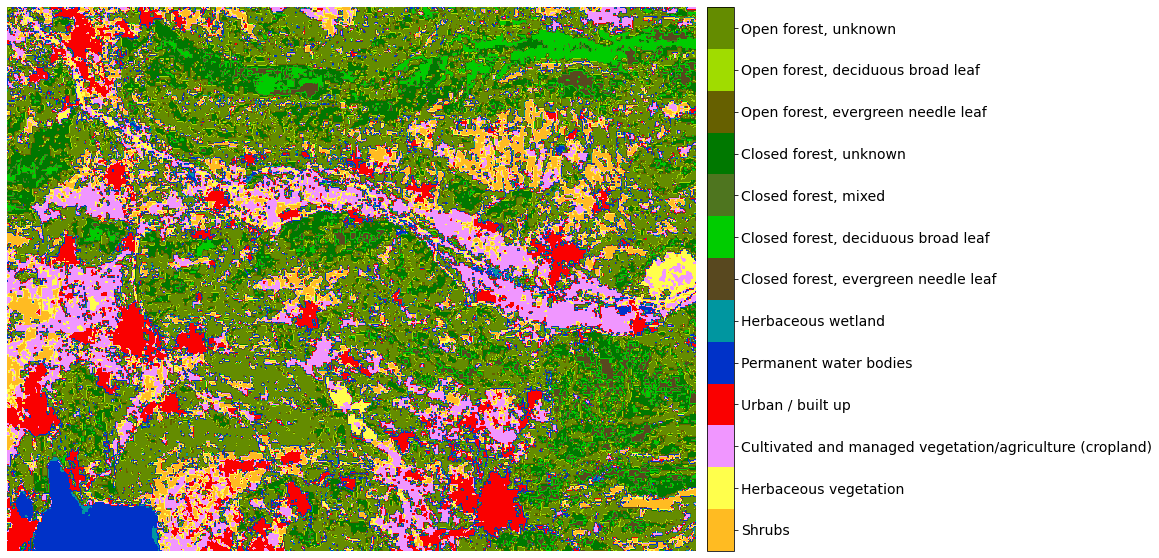

In [231]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = plt.imshow(eopatch_glc.data["GLC_data"][0][..., [0]].squeeze(), cmap=glc_cmap, norm=glc_norm)
plt.axis(False)

cb = fig.colorbar(im, orientation="vertical", pad=0.01, aspect=20)

cb.set_ticks(glc_ticks)
cb.set_ticklabels([entry[0] for entry in GLC_sub], fontsize=14);

### 6.  Global Surface Water ( [GSW](https://collections.sentinel-hub.com/global-surface-water/readme.html) )

In [113]:
gsw_data_collection = DataCollection.define_byoc(
    "9a525f12-33b6-424e-a0f2-d567eec0f277",
    service_url="https://creodias.sentinel-hub.com",
    bands=[Band(name="occurrence", units=(Unit.DN,), output_types=(np.uint8))],
)

In [114]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["occurrence"],
    output: [
        {
          id: "GSW_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.occurrence];
}
"""

In [115]:
gsw_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "GSW_data"),
    evalscript=evalscript,
    data_collection=gsw_data_collection,
    resolution=30,
    max_threads=3,
)

In [280]:
eopatch_gsw = gsw_download_task.execute(bbox=roi1_bbox, time_interval=["2020-01-01", "2020-12-01"])

In [281]:
class GSW(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NOT_WATER = "Not water", 0, "#ffffff"
    PERCENT_1 = "1% occurrence", 1, "#ffcccc"
    PERCENT_100 = "100% occurrence", 100, "#0000ff"
    NO_DATA = "No data", 255, "#cccccc"

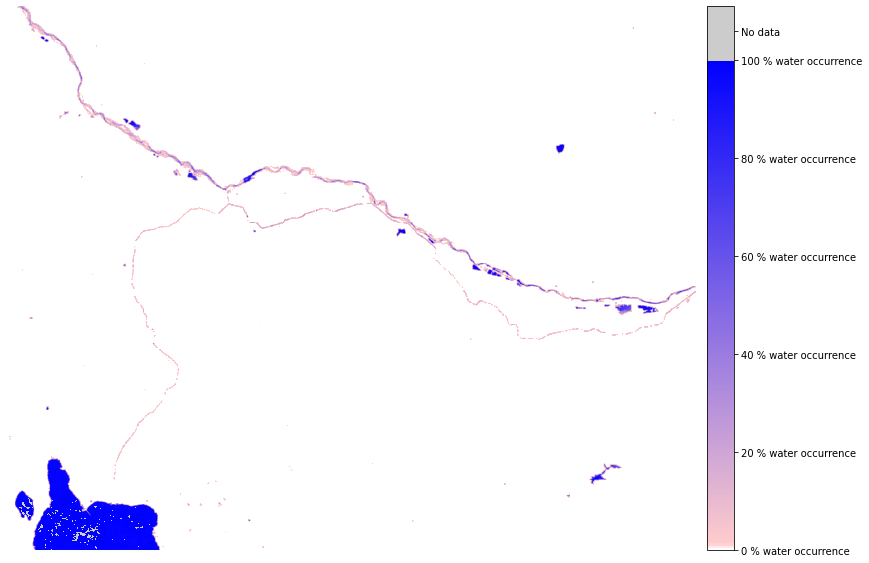

In [282]:
GSW_rows = []
[GSW_rows.append([entry.values[0], entry.values[1], entry.values[2]]) for entry in GSW]

GSW_clrs = []
[GSW_clrs.append(rgb_int(entry)) for entry in GSW_rows]


GSW_vals = eopatch_gsw.data["GSW_data"]
norm = plt.Normalize(0, 111)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", GSW_clrs[0:-1])
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [(0, GSW_clrs[0]), (0.009, GSW_clrs[1]), (0.9, GSW_clrs[2]), (0.901, GSW_clrs[3]), (1, GSW_clrs[3])]
)

gws_norm = BoundaryNorm([1, 111], 2)

plt.figure(figsize=(20, 10))
plt.imshow(eopatch_gsw.data["GSW_data"].squeeze(), cmap=cmap1, norm=norm)
plt.axis(False)

ticks = [i for i in range(0, 101, 20)]
ticks.append(106)
tick_labels = [f"{i} % water occurrence" for i in range(0, 101, 20)]
tick_labels.append("No data")

cb = plt.colorbar(pad=0.01)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels)

### 7.  Global Human Settlements Layer  ( [GHSL](https://collections.sentinel-hub.com/global-human-settlement-layer-ghs-built-s2/) )

In [118]:
ghsl_data_collection = DataCollection.define_byoc(
    "3dbeea2c-3207-4c65-8a73-c29ce2675f89",
    service_url="https://creodias.sentinel-hub.com",
    bands=[
        Band(
            name="PROB",
            units=(Unit.DN,),
            output_types=(np.uint8,),
        )
    ],
)

In [119]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["PROB"],
    output: [
        {
          id: "GHSL_PROB",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.PROB];
}
"""

In [120]:
ghsl_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "GHSL_PROB"),
    evalscript=evalscript,
    data_collection=ghsl_data_collection,
    resolution=30,
    max_threads=3,
)

In [246]:
eopatch_ghsl = ghsl_download_task.execute(bbox=roi1_bbox, time_interval=["2017-01-01", "2019-01-01"])

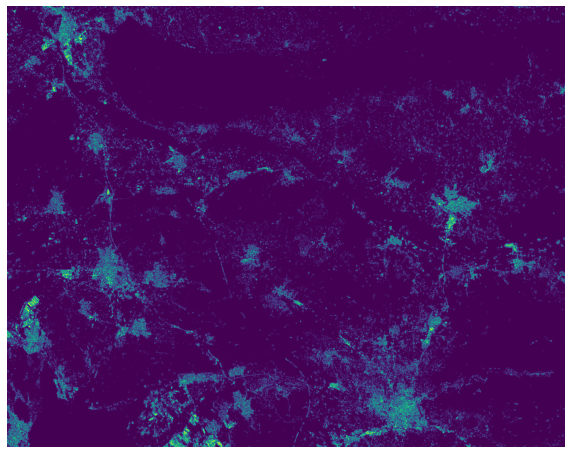

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(eopatch_ghsl.data["GHSL_PROB"].squeeze())
plt.axis(False);

### 8.  Theia (CNES) Land Cover Map  ( [TLCM](https://collections.sentinel-hub.com/cnes-land-cover-map/) )

In [233]:
tlcm_data_collection = DataCollection.define_byoc(
    "9baa2732-6597-49d2-ae3b-68ba0a5386b2",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name="OCS", units=(Unit.DN,), output_types=(np.uint8))],
)

In [234]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["OCS"],
    output: [
        {
          id: "TLCM_data",
          bands: 1,
          sampleType: "UINT8"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.OCS];
}
"""

In [235]:
tlcm_download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "TLCM_data"),
    evalscript=evalscript,
    data_collection=tlcm_data_collection,
    resolution=30,
    max_threads=3,
)

In [236]:
eopatch_tlcm = tlcm_download_task.execute(bbox=roi1_bbox, time_interval=["2020-01-01", "2020-12-01"])

In [237]:
class TLCM(MultiValueEnum):
    """Enum class containing basic LULC types"""

    E1 = "Dense built-up area", 1, "#ff00ff"
    E2 = "Diffuse built-up area", 2, "#ff55ff"
    E3 = "Industrial and commercial areas", 3, "#ffaaff"
    E4 = "Roads", 4, "#00ffff"
    E5 = "Oilseeds (Rapeseed)", 5, "#ffff00"
    E6 = "Straw cereals (Wheat, Triticale, Barley)", 6, "#d0ff00"
    E7 = "Protein crops (Beans / Peas)", 7, "#a1d600"
    E8 = "Soy", 8, "#ffab44"
    E9 = "Sunflower", 9, "#d6d600"
    E10 = "Corn", 10, "#ff5500"
    E11 = "Rice", 11, "#c5ffff"
    E12 = "Tubers/roots", 12, "#aaaa61"
    E13 = "Grasslands", 13, "#aaaa00"
    E14 = "Orchards and fruit growing", 14, "#aaaaff"
    E15 = "Vineyards", 15, "#550000"
    E16 = "Hardwood forest", 16, "#009c00"
    E17 = "Softwood forest", 17, "#003200"
    E18 = "Natural grasslands and pastures", 18, "#aaff00"
    E19 = "Woody moorlands", 19, "#55aa7f"
    E20 = "Natural mineral surfaces", 20, "#ff0000"
    E21 = "Beaches and dunes", 21, "#ffb802"
    E22 = "Glaciers and eternal snows", 22, "#bebebe"
    E23 = "Water", 23, "#0000ff"

In [238]:
TLCM_sub = []
TLCM_un = np.unique(eopatch_tlcm.data["TLCM_data"])

for i, entry in enumerate(TLCM):
    if np.isin(entry.values[1], TLCM_un):
        TLCM_sub.append([entry.values[0], entry.values[1], entry.values[2]])

tlcm_bounds = [TLCM_sub[0][1] - 0.5]
[tlcm_bounds.append((0.5 + entry[1])) for entry in TLCM_sub]
tlcm_ticks = [np.mean([tlcm_bounds[i], tlcm_bounds[i - 1]]) for i in range(1, len(tlcm_bounds))]

tlcm_cmap = ListedColormap([rgb_int(entry) for entry in TLCM_sub], name="tlcm_cmap")
tlcm_norm = BoundaryNorm(tlcm_bounds, tlcm_cmap.N)

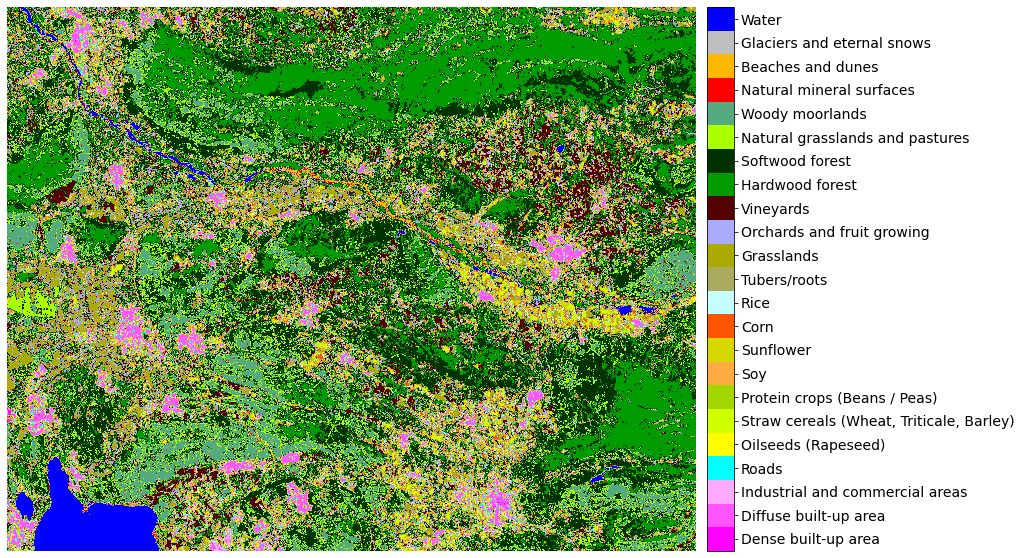

In [239]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im1 = plt.imshow(eopatch_tlcm.data["TLCM_data"].squeeze(), cmap=tlcm_cmap, norm=tlcm_norm)
im2 = plt.imshow(eopatch_tlcm.data["TLCM_data"][0].squeeze(), cmap=tlcm_cmap)
plt.axis(False)

cb = fig.colorbar(im1, orientation="vertical", pad=0.01, aspect=20)
cb.set_ticks(tlcm_ticks)
cb.set_ticklabels([entry[0] for entry in TLCM_sub], fontsize=14);

### 9. Sentinel-2 Scene Classification Layer (from [Sen2Cor](https://www.sentinel-hub.com/develop/api/ogc/custom-parameters/atmospheric-correction/))

In [241]:
scl_data = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    additional_data=[(FeatureType.MASK, "SCL")],
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(hours=2),
    max_threads=3,
)

In [242]:
scl_eopatch = scl_data.execute(bbox=roi_bbox, time_interval=["2022-07-03", "2022-07-05"])

In [243]:
class SCL(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NO_DATA = "no data", 0, "#000000"
    SATURATED_DEFECTIVE = "saturated / defective", 1, "#ff0004"
    DARK_AREA_PIXELS = "dark area pixels", 2, "#868686"
    CLOUD_SHADOWS = "cloud shadows", 3, "#774c0b"
    VEGETATION = "vegetation", 4, "#10d32d"
    BARE_SOILS = "bare soils", 5, "#ffff53"
    WATER = "water", 6, "#0000ff"
    CLOUDS_LOW_PROBA = "clouds low proba.", 7, "#818181"
    CLOUDS_MEDIUM_PROBA = "clouds medium proba.", 8, "#c0c0c0"
    CLOUDS_HIGH_PROBA = "clouds high proba.", 9, "#f2f2f2"
    CIRRUS = "cirrus", 10, "#bbc5ec"
    SNOW_ICE = "snow / ice", 11, "#53fffa"

    @property
    def rgb(self):
        return [c / 255.0 for c in self.rgb_int]

    @property
    def rgb_int(self):
        hex_val = self.values[2][1:]
        return [int(hex_val[i : i + 2], 16) for i in (0, 2, 4)]


scl_bounds = [-0.5 + i for i in range(len(SCL) + 1)]
scl_cmap = ListedColormap([x.rgb for x in SCL], name="scl_cmap")
scl_norm = BoundaryNorm(scl_bounds, scl_cmap.N)

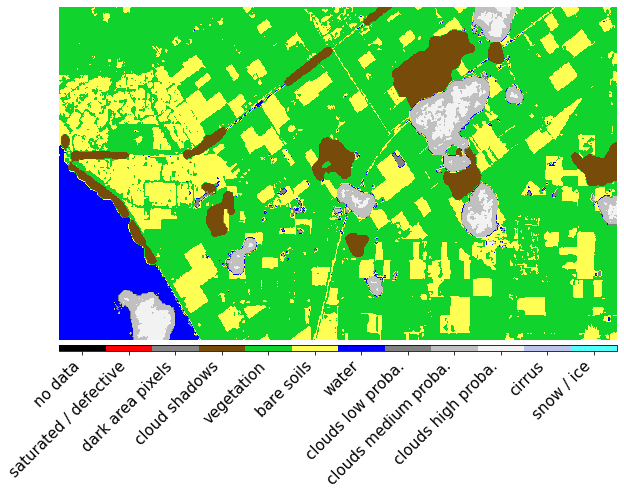

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = plt.imshow(scl_eopatch.mask["SCL"][0].squeeze(), cmap=scl_cmap, norm=scl_norm)
plt.axis(False)

cb = fig.colorbar(im, orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.values[1] for entry in SCL])
cb.ax.set_xticklabels([entry.values[0] for entry in SCL], rotation=45, fontsize=15, ha="right");